In [2]:
import matplotlib.pyplot as plt
import numpy as np

import nsta.tcspcdata, nsta.tadata, nsta.analysis

import importlib
nsta.analysis = importlib.reload(nsta.analysis)

In [25]:
ta_data = nsta.tadata.TAData()
ta_data.delta_od = "../../trans-MeOPAP-RP/TA/trans-MeOPAP-RP_PSS435_CHX_312nm_12ns_2001ms_10ps/0001/trans-MeOPAP-RP_PSS435_CHX_312_12ns_NS_2D_DeltaOD_uncor.dat"
ta_data.missed_shots = "../../trans-MeOPAP-RP/TA/trans-MeOPAP-RP_PSS435_CHX_312nm_12ns_2001ms_10ps/0001/trans-MeOPAP-RP_PSS435_CHX_312_12ns_NS_missed_shots.dat"
ta_data.status_numbers = "../../trans-MeOPAP-RP/TA/trans-MeOPAP-RP_PSS435_CHX_312nm_12ns_2001ms_10ps/0001/trans-MeOPAP-RP_PSS435_CHX_312_12ns_NS_cmbstatusnumber.dat"

tcspc_data = nsta.tcspcdata.TCSPCData()
tcspc_data.delays_directory = "../../trans-MeOPAP-RP/TCSPC/trans-MeOPAP-RP_PSS435_CHX_312nm_12ns_2001ms_10ps"

num spectra before processing: 72943
num spectra after processing: 72943


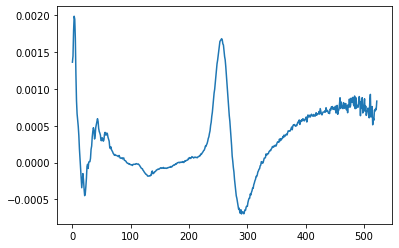

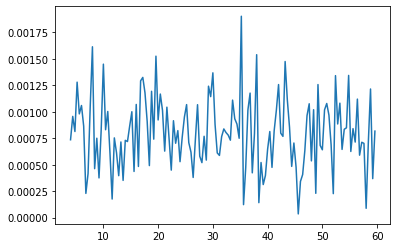

In [26]:
print("num spectra before processing:", ta_data.num_spectra)

ana = nsta.analysis.TATCSCPAnalysis(ta_data, tcspc_data)
ana._delay_offsets = np.zeros(ana.ta_data.num_steps, dtype=np.int) - 1
ana.process_data()

# plt.figure()
# plt.plot(ana.delay_statistics[0], ana.delay_statistics[1])
# plt.show()

wl, od = ana.plot_spectrum(ana.ta_data.delta_od)
plt.figure()
plt.plot(wl, od)
plt.show()

t, od = ana.plot_transient(220, 260)
plt.figure()
plt.plot(t, od)
plt.show()

In [27]:
np.savetxt('trans-MeOPAP-RP_PSS435_CHX_312nm_12ns_2001ms_10ps_delays.dat', ana.tcspc_data_processed, fmt='%.3e')
np.savetxt('trans-MeOPAP-RP_PSS435_CHX_312nm_12ns_2001ms_10ps_2d_data.dat', ana.ta_data_processed, fmt='%.12e')

# nur bis hierhin ausgeführt

num spectra after processing: 72982
num spectra after processing: 72982
num spectra after processing: 72982


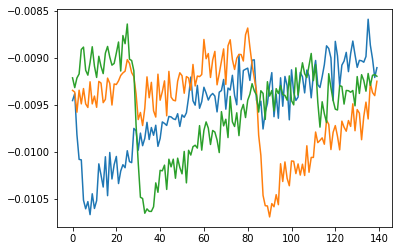

In [14]:
ana._delay_offsets = np.zeros(ana.ta_data.num_steps, dtype=np.int) - 1
ana.process_data()
_, od0 = ana.plot_transient(260, 340)
t = np.arange(*od0.shape) # x-axis as index

ana._delay_offsets = np.zeros(ana.ta_data.num_steps, dtype=np.int) - 2
ana.process_data()
_, od1 = ana.plot_transient(260, 340)

ana._delay_offsets = np.zeros(ana.ta_data.num_steps, dtype=np.int) - 3
ana.process_data()
_, od2 = ana.plot_transient(260, 340)

plt.figure()
plt.plot(t, od0, t, od1, t, od2)
plt.show()

# Versuch 5: Iterative Brute Force Geradenregression

num spectra after processing: 72982


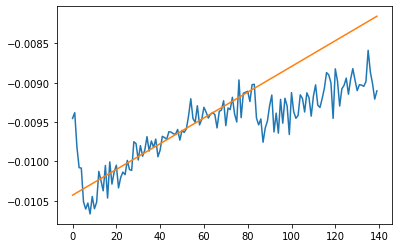

In [13]:
# Fit mit linregress
ana._delay_offsets = np.zeros(ana.ta_data.num_steps, dtype=np.int) - 1
ana.process_data()
_, od = ana.plot_transient(260, 340)
t = np.arange(*od.shape) # x-axis as index

from scipy import stats
s = slice(15, 75)
slope, intercept, _, _, _ = stats.linregress(t[s], od[s])
fit = intercept + slope * t

plt.figure()
plt.plot(t, od, t, fit)
plt.show()

In [16]:
from scipy.optimize import curve_fit

def err(offsets, ana, slc):
    ana._delay_offsets = offsets
    ana.process_data()
    _, od = ana.plot_transient(260, 340)

    popt, _ = curve_fit(lambda x, b: slope*x + b, t[s], od[s])
    target = popt[0] + slope * t

    err = target - od
    err = err[slc]
    print('err =', np.sum(err**2))
    return np.sum(err**2)

offsets = np.zeros(ana.ta_data.num_steps, dtype=np.int) - 1
slc = slice(90, 140)

test_values = [0, -1, -2]
for i in range(ana.ta_data.num_steps):
    new_offsets = []
    for val in test_values:
        new = offsets.copy()
        new[i] = val
        new_offsets.append(new)
    new_offsets = np.array(new_offsets)

    new_errs = [err(off, ana, slc) for off in new_offsets]
    min_err_idx = new_errs.index(min(new_errs))
    offsets[i] = test_values[min_err_idx]
    print(offsets)

print(repr(offsets))

1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1
 -1  0 -1 -1 -1 -1 -2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]
num spectra after processing: 72982
err = 8.009701706411914e-06
num spectra after processing: 72982
err = 7.803034825518894e-06
num spectra after processing: 72982
err = 8.143247803059368e-06
[-1  0 -2  0  0 -2  0 -2 -1  0 -1 -1 -1 -1 -1 -2  0 -1  0 -1 -1 -1 -1 -1
  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -2 -1 -1 -1  0 -1 -1 -1
 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1
 -1  0 -1 -1 -1 -1 -2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]
num spectra after processing: 72982
err = 8.080993704361444e-06
num spectra after processing: 72982
err = 7.803034825518894e-06
num spectra after processing: 729

num spectra after processing: 72982


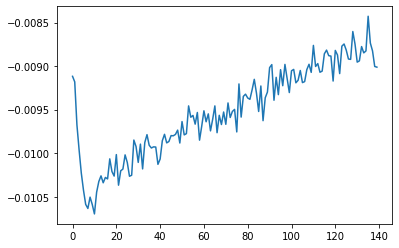

In [17]:
offsets_from_v5 = np.array([-1,  0, -2,  0,  0, -2,  0, -2, -1,  0, -1, -1, -1, -1, -1, -2,  0,
       -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0,  0, -1, -1, -1, -2, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0,
       -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1,  0, -1, -1,  0,  0, -1,  0, -1, -1, -1,  0, -1,
       -1,  0, -1, -1, -1, -1, -1,  0, -1, -1])

ana._delay_offsets = offsets_from_v5
ana.process_data()
_, od = ana.plot_transient(260, 340)
t = np.arange(*od.shape) # x-axis as index

plt.figure()
plt.plot(t, od)
plt.show()